In [1]:
from PIL import Image
import warnings

from keras.integration_test.preprocessing_test_utils import BATCH_SIZE
from mpmath import residual
from win32con import SB_LEFT

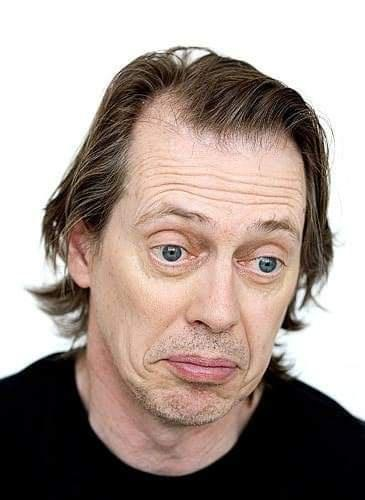

In [2]:
img = Image.open('data/image.jpeg')
img

In [3]:
from transformers import AutoProcessor, SiglipVisionModel, SiglipVisionConfig

warnings.filterwarnings('ignore')

processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
vision_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224", config=SiglipVisionConfig(vision_use_head=None))

vision_model

C:\Users\sammi\anaconda3\envs\tensorflow-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bi

In [4]:
import torch
from torch import nn
import torch.nn.functional as Functional
from dataclasses import dataclass

from torchvision import transforms

def preprocess_image(image, image_size=224):
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image_tensor = preprocess(image)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    
    return image_tensor

In [5]:
image_tensor = preprocess_image(img)

embed_dim = 768
patch_size = 16
image_size = 224
num_patches = (image_size // patch_size) ** 2

with torch.no_grad():
    patch_embeddings = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
    patches = patch_embeddings(image_tensor)
    
patches.shape, num_patches

(torch.Size([1, 768, 14, 14]), 196)

In [6]:
position_embedding = nn.Embedding(num_patches, embed_dim)
position_ids = torch.arange(num_patches).expand((1, -1))

position_ids.shape

torch.Size([1, 196])

In [7]:
embeddings = patches.flatten(start_dim=2, end_dim=-1)
embeddings = embeddings.transpose(1, 2)
embeddings = embeddings + position_embedding(position_ids)

embeddings.shape

torch.Size([1, 196, 768])

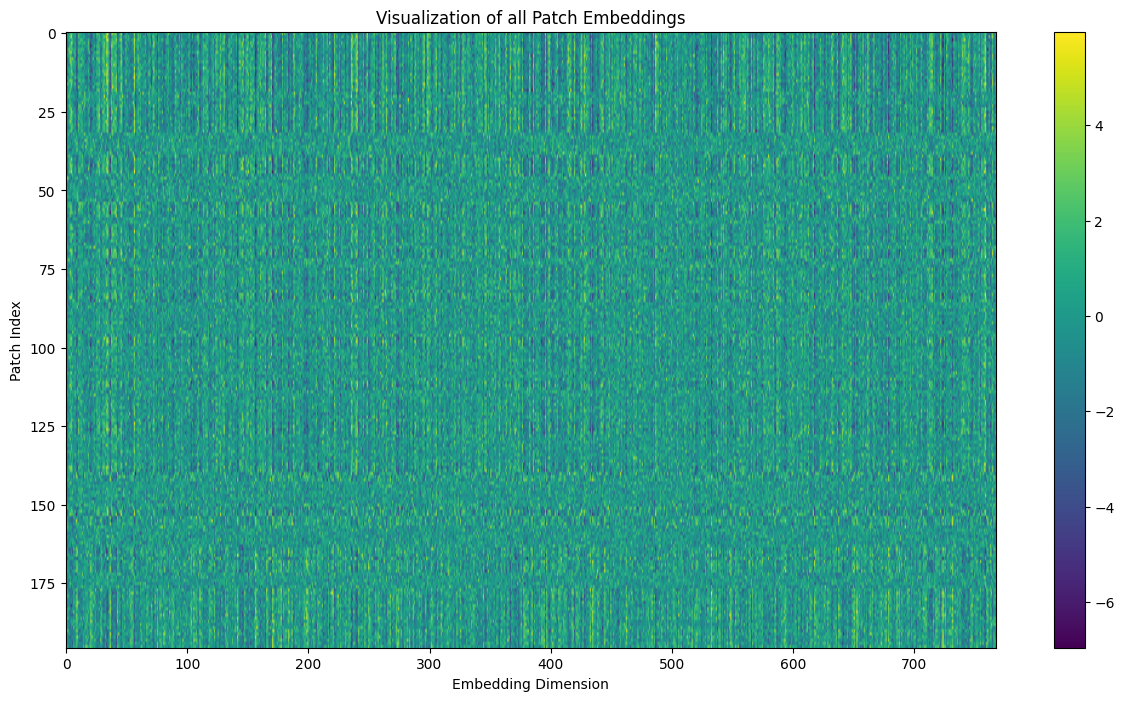

In [8]:
import matplotlib.pyplot as plt

patches_viz = embeddings[0].detach().numpy()

plt.figure(figsize=(15, 8))
plt.imshow(patches_viz, aspect='auto', cmap='viridis')
plt.colorbar()

plt.title('Visualization of all Patch Embeddings')
plt.ylabel('Patch Index')
plt.xlabel('Embedding Dimension')

plt.show()

torch.Size([1, 196, 768])


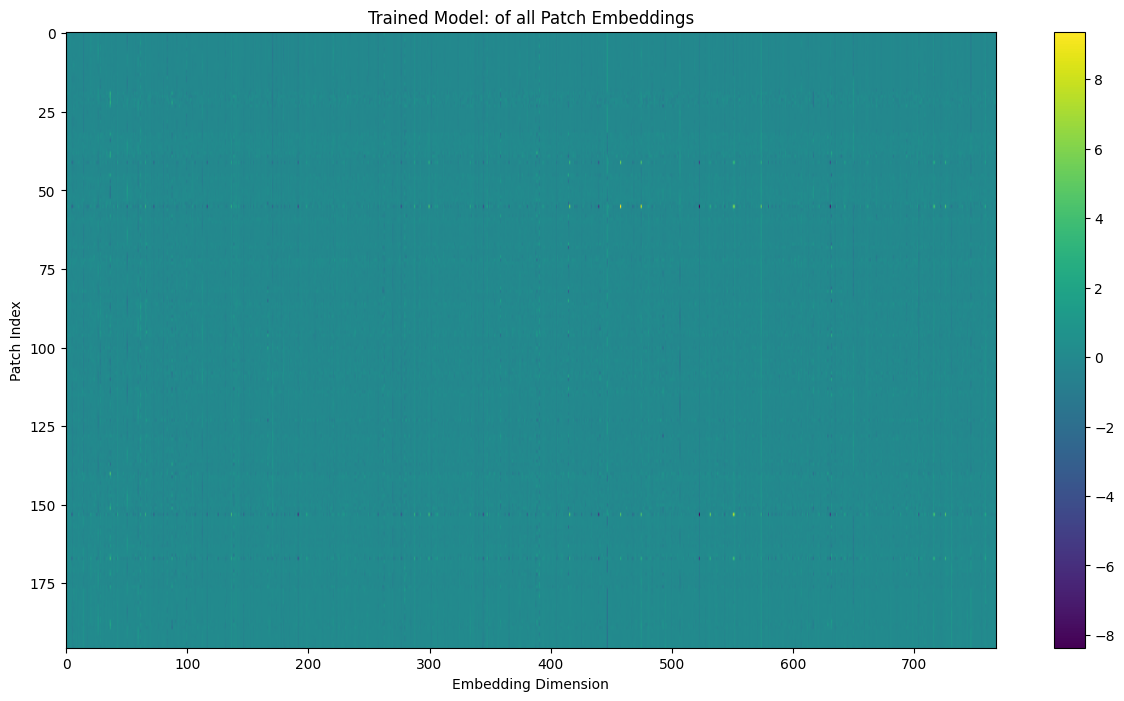

In [9]:
vision_model.eval()
inputs = processor(images=img, return_tensors="pt")

with torch.no_grad():
    patch_embeddings = vision_model.vision_model.embeddings(inputs.pixel_values)
    
print(patch_embeddings.shape)

patches_viz = patch_embeddings[0].detach().numpy()

plt.figure(figsize=(15, 8))
plt.imshow(patches_viz, aspect='auto', cmap='viridis')
plt.colorbar()

plt.title('Trained Model: of all Patch Embeddings')
plt.ylabel('Patch Index')
plt.xlabel('Embedding Dimension')

plt.show()

In [10]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    embed_dim: int = 768
    
class SiglipVisionEmbeddings(nn.Module):
    def __init__(self, vision_config: SiglipVisionConfig):
        super().__init__()
        self.vision_config = vision_config
        
        self.num_channels = self.vision_config.num_channels
        self.image_size = self.vision_config.image_size
        self.patch_size = self.vision_config.patch_size
        self.embed_dim = self.vision_config.embed_dim
        
        self.patch_embedding = nn.Conv2d(
            in_channels=self.num_channels, out_channels=self.embed_dim, 
            kernel_size=self.patch_size, stride=self.patch_size, 
            padding='valid'
        )
        
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
        
        self.register_buffer(
            'position_ids', 
            torch.arange(self.num_positions).expand((1, -1)), 
            persistent=False
        )
        
    def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
        BATCHES, CHANNELS, HEIGHT, WIDTH = pixel_values.shape
        
        patch_embeddings = self.patch_embedding(pixel_values)
        
        embeddings = patch_embeddings.flatten(start_dim=2, end_dim=-1)
        embeddings = embeddings.transpose(1, 2)
        embeddings = embeddings + self.position_embedding(self.position_ids)
        
        return embeddings

In [11]:
embed = SiglipVisionEmbeddings(SiglipVisionConfig())
embed(image_tensor).shape

torch.Size([1, 196, 768])

In [12]:
# Sanity check

from transformers import SiglipVisionModel as HFSiglipVisionModel

our_state_dict = embed.state_dict()
hf_state_dict = {k.replace("vision_model.embeddings.", ""): v for k, v in vision_model.state_dict().items() if "vision_model.embeddings." in k}
our_state_dict.update(hf_state_dict)
embed.load_state_dict(our_state_dict)

with torch.no_grad():
    our_output = embed(image_tensor)
    hf_output = vision_model.vision_model.embeddings(image_tensor)
    print(f"Max diff between our and HF output: {torch.max(torch.abs(our_output - hf_output))}")

Max diff between our and HF output: 0.0


In [13]:
import math

class Head(nn.Module):
    """ A single head of the multi-head attention layer """
    
    def __init__(self, n_in, n_head, context_length):
        super().__init__()
        self.head_size = n_head
        self.key = nn.Linear(n_in, n_head, bias=False)
        self.value = nn.Linear(n_in, n_head, bias=False)
        self.query = nn.Linear(n_in, n_head, bias=False)
        
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_size))
        wei = Functional.softmax(wei, dim=-1)
        out = wei @ v
        
        return out


class MultiHeadAttention(nn.Module):
    """ Multi-head attention implementation with concatenating every head's output """

    def __init__(self, num_head, n_in, head_size, context_length):
        super().__init__()
        self.head_size = head_size
        self.num_head = num_head
        self.heads = [Head(n_in, head_size, context_length) for _ in range(num_head)]
        # self.heads = nn.ModuleList([Head(n_in, head_size, context_length) for _ in range(num_head)])
        self.proj = nn.Linear(n_in, n_in)

    def forward(self, x):
        out = [h(x) for h in self.heads]
        out = torch.concat(out, dim=-1)
        out = self.proj(out)

        return out

In [14]:
num_attention_heads = 12
hidden_size = 768

attention = MultiHeadAttention(num_head=12, n_in=768, head_size=64, context_length=196)
attention(torch.randn(1, 196, 768))

tensor([[[-0.0812, -0.0237,  0.0301,  ...,  0.0397, -0.0172, -0.0248],
         [-0.0936, -0.0572,  0.0264,  ...,  0.0353, -0.0296, -0.0374],
         [-0.0798, -0.0506,  0.0193,  ...,  0.0427, -0.0157, -0.0445],
         ...,
         [-0.0803, -0.0340,  0.0071,  ...,  0.0106, -0.0085, -0.0322],
         [-0.0753, -0.0352,  0.0120,  ...,  0.0243,  0.0043, -0.0329],
         [-0.0789, -0.0427,  0.0399,  ...,  0.0427, -0.0137, -0.0282]]],
       grad_fn=<ViewBackward0>)

In [15]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    attention_dropout: float = 0.0

class SiglipAttention(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.dropout = config.attention_dropout

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, hidden_states):
        B, T, C = hidden_states.shape
        q_states = self.q_proj(hidden_states)
        k_states = self.k_proj(hidden_states)
        v_states = self.v_proj(hidden_states)
        
        q_states = q_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
        k_states = k_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
        v_states = v_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
        
        attention_weights = (q_states @ k_states.transpose(-2, -1)) * (1.0 / math.sqrt(k_states.size(-1)))
        attention_weights = Functional.softmax(attention_weights, dim=-1).to(q_states.dtype)
        attention_weights = Functional.dropout(attention_weights, p=self.dropout, training=self.training)
        attn_output = attention_weights @ v_states
        attn_output = attn_output.transpose(1, 2)
        attn_output = attn_output.reshape(B, T, C).contiguous()
        attn_output = self.out_proj(attn_output)
        
        return attn_output

In [16]:
BATCH_SIZE = 1
NUM_PATCHES = 196
EMBEDDING_DIM = 768

hidden_states = torch.randn(BATCH_SIZE, NUM_PATCHES, EMBEDDING_DIM)

config = SiglipVisionConfig(
    num_attention_heads=12,
    hidden_size=768,
    attention_dropout=0.0
)

attention = SiglipAttention(config)
output = attention(hidden_states)

print(f'Input shape: {hidden_states.shape}')
print(f'Output shape: {output.shape}')

Input shape: torch.Size([1, 196, 768])
Output shape: torch.Size([1, 196, 768])


In [17]:
hf_state_dict = vision_model.vision_model.state_dict()
our_state_dict = attention.state_dict()

key_mapping = {
    'k_proj.weight': 'encoder.layers.0.self_attn.k_proj.weight',
    'k_proj.bias': 'encoder.layers.0.self_attn.k_proj.bias',
    'v_proj.weight': 'encoder.layers.0.self_attn.v_proj.weight',
    'v_proj.bias': 'encoder.layers.0.self_attn.v_proj.bias',
    'q_proj.weight': 'encoder.layers.0.self_attn.q_proj.weight',
    'q_proj.bias': 'encoder.layers.0.self_attn.q_proj.bias',
    'out_proj.weight': 'encoder.layers.0.self_attn.out_proj.weight',
    'out_proj.bias': 'encoder.layers.0.self_attn.out_proj.bias'
}

for our_key, hf_key in key_mapping.items():
    our_state_dict[our_key].copy_(hf_state_dict[hf_key])
    
attention.load_state_dict(our_state_dict)

with torch.no_grad():
    our_output = attention(hidden_states)
    hf_output = vision_model.vision_model.encoder.layers[0].self_attn(hidden_states)[0]
    max_diff = torch.max(torch.abs(hf_output - our_output))
    
    print(f'Max diff between our output and HF output: {max_diff:.6f}')
    print((torch.isclose(our_output, hf_output, atol=1e-6) == 0).sum())

Max diff between our output and HF output: 0.000001
tensor(0)


In [18]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    attention_dropout: float = 0.0
    intermediate_size: int = 3072
    # hidden_act: str = 'gelu'

class SiglipMLP(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc1(hidden_states)
        hidden_states = nn.functional.gelu(hidden_states, approximate="tanh")
        hidden_states = self.fc2(hidden_states)
        
        return hidden_states

In [19]:
mlp = SiglipMLP(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
mlp(torch.randn(1, 196, 768)).shape

torch.Size([1, 196, 768])

In [20]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    attention_dropout: float = 0.0
    intermediate_size: int = 3072
    layer_norm_eps: float = 1e-6
    
class SiglipVisionEmbeddings(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        
        self.num_channels = config.num_channels
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        
        self.patch_embedding = nn.Conv2d(
            in_channels=self.num_channels, out_channels=self.embed_dim,
            kernel_size=self.patch_size, stride=self.patch_size,
            padding="valid"
        )
        
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
        
        self.register_buffer(
            "position_ids", 
            torch.arange(self.num_positions).expand((1, -1)),
            persistent=False
        )
        
    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        BATCHES, CHANNELS, HEIGHT, WIDTH = pixel_values.shape
        
        patch_embeds = self.patch_embedding(pixel_values)
        embeddings = patch_embeds.flatten(start_dim=2, end_dim=-1)
        embeddings = embeddings.transpose(1, 2)
        embeddings = embeddings + self.position_embedding(self.position_ids)
        
        return embeddings

In [21]:
class SiglipEncoderLayer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        
        self.embd_dim = config.hidden_size
        self.self_attention = SiglipAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embd_dim, eps=config.layer_norm_eps)
        self.mlp = SiglipMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embd_dim, eps=config.layer_norm_eps)
        
    def forward(self, hidden_states):
        residual = hidden_states
        hidden_states = self.layer_norm1(hidden_states)
        hidden_states = self.self_attention(hidden_states)
        hidden_states = residual + hidden_states
        
        residual = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states
        
        return hidden_states

In [22]:
encoder_layer = SiglipEncoderLayer(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
encoder_layer(torch.randn(1, 196, 768)).shape

torch.Size([1, 196, 768])

In [23]:
vision_model

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bi

In [24]:
@dataclass
class SiglipVisionConfig:
    num_hidden_layers: int = 12
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    intermediate_size: int = 3072
    layer_norm_eps: float = 1e-6
    attention_dropout: float = 0.0
    
class SiglipEncoder(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList([SiglipEncoderLayer(config) for _ in range(config.num_hidden_layers)])
        
    def forward(self, hidden_states):
        for layer in self.layers:
            hidden_states = layer(hidden_states)
            
        return hidden_states

In [25]:
encoder = SiglipEncoder(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
encoder(torch.randn(1, 196, 768)).shape

torch.Size([1, 196, 768])

In [26]:
class SiglipVisionTransformer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.embeddings = SiglipVisionEmbeddings(config)
        self.encoder = SiglipEncoder(config)
        self.post_layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        
    def forward(self, pixel_values):
        hidden_states = self.embeddings(pixel_values)
        last_hidden_states = self.encoder(hidden_states)
        last_hidden_states = self.post_layer_norm(last_hidden_states)
        
        return last_hidden_states

In [27]:
siglip_vision_transformer = SiglipVisionTransformer(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
siglip_vision_transformer(image_tensor).shape

torch.Size([1, 196, 768])

In [28]:
class SiglipModel(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.vision_model = SiglipVisionTransformer(config)
        
    def forward(self, pixel_values):
        return self.vision_model(pixel_values)

In [29]:
siglip_model = SiglipModel(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
siglip_model(image_tensor).shape

torch.Size([1, 196, 768])

In [30]:
hf_state_dict = vision_model.state_dict()
our_state_dict = siglip_model.state_dict()

renamed_hf_state_dict = {}
for key, value in hf_state_dict.items():
    new_key = key.replace("self_attn", "self_attention").replace("post_layernorm", "post_layer_norm")
    renamed_hf_state_dict[new_key] = value

siglip_model.load_state_dict(renamed_hf_state_dict)

<All keys matched successfully>